# Handwritten Digit Recognition

Objective: Classify handwritten digits from the MNIST dataset by training a convolutional neural network (CNN) using the [Keras](https://keras.io) deep learning library.

## Data Preparation

We begin by downloading the data and creating training & validation sets. Keras has inbuilt helper functions to do this.

In [4]:
import jovian

In [5]:
jovian.log_dataset(from_date='2019-01-01', to_date='2020-01-01', url='s3://something')

[jovian] Dataset logged.


In [1]:
from keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

Using TensorFlow backend.


Each sample is a 28px x 28 px image, flattened out a vector of length 784 i.e. 28x28.

In [2]:
train_images[0].shape, train_labels[0]

((28, 28), 5)

Let's take a look at some sample images from the training set, by plotting them in a grid.

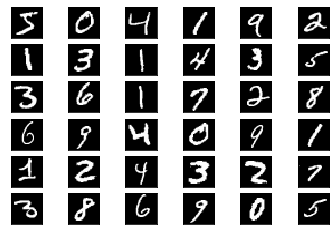

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

grid_size = 6
f, axarr = plt.subplots(grid_size, grid_size)
for i in range(grid_size):
    for j in range(grid_size):
        ax = axarr[i, j]
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.imshow(train_images[i * grid_size + j], cmap='gray')

We're going to apply the following preprocessing steps:
1. Reshape the image vectors into 28x28 matrices
2. Separate 20% of the training set to create a vaidation set
3. Conver the numeric labels into one-hot vectors

In [4]:
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

from keras.utils import to_categorical

partial_train_images = train_images[:45000]
partial_train_labels = train_labels[:45000]

validation_images = train_images[45000:]
validation_labels = train_labels[45000:]

partial_train_labels = to_categorical(partial_train_labels)
validation_labels = to_categorical(validation_labels)
test_labels = to_categorical(test_labels)

## Model & Training

Now we're ready to define a simple CNN model.

In [5]:
input_shape = (28,28,1)
num_classes = 10

In [6]:
jovian.log_hyperparams(arch='2layerCNN', batch_size=128, lr=0.001)

[jovian] Hyperparams logged.


In [6]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                54090     
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
_________________________________________________________________


In [7]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
history = model.fit(
    partial_train_images, 
    partial_train_labels, 
    epochs=3, 
    batch_size=128, 
    validation_data=(validation_images, validation_labels))

Instructions for updating:
Use tf.cast instead.
Train on 45000 samples, validate on 15000 samples
Epoch 1/3
45000/45000 [==============================] - 15s 324us/step - loss: 0.3704 - acc: 0.8977 - val_loss: 0.1856 - val_acc: 0.9500
Epoch 2/3
45000/45000 [==============================] - 13s 286us/step - loss: 0.1466 - acc: 0.9590 - val_loss: 0.1247 - val_acc: 0.9641
Epoch 3/3
45000/45000 [==============================] - 13s 290us/step - loss: 0.0982 - acc: 0.9726 - val_loss: 0.0970 - val_acc: 0.9719


In [7]:
jovian.log_metrics(loss=0.0982,acc= 0.9726)

[jovian] Metrics logged.


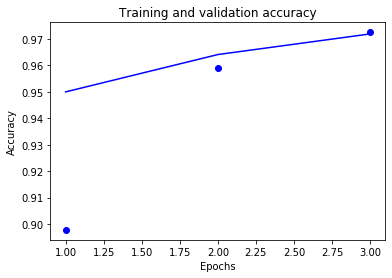

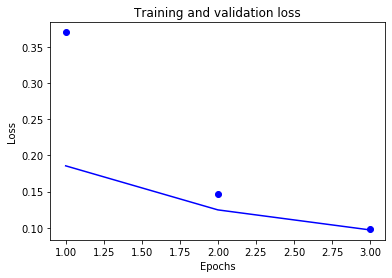

In [9]:
import matplotlib.pyplot as plt

acc = history.history['acc']
loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.margins(0.05)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.margins(0.05)

plt.show()

## Model Evaluation

In [10]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

10000/10000 [==============================] - 1s 99us/step


In [11]:
print('Test loss:', test_loss)
print('Test acc:', test_acc)

Test loss: 0.08638658923842013
Test acc: 0.9745


We can also save the trained model's weights to disk, so we won't need to train it again.

In [12]:
model.save('mnist-cnn.h5')

## Save & Commit

In [1]:
!pip install jovian --upgrade

Requirement already up-to-date: jovian in /Users/aakashns/miniconda3/envs/zerotopandas/lib/python3.8/site-packages (0.2.18)


In [2]:
import jovian

In [ ]:
jovian.commit(project='keras-mnist-jovian-demo', outputs=['model.pkl'])

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..


In [10]:
!echo "some weights" >> model.pkl